In [15]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import ast
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [16]:
dfOrig = pd.read_csv("tedTalksFlattened.csv")
del dfOrig["Unnamed: 0"]
dfOrig = dfOrig.rename(columns = {'Jaw-dropping': 'JawDropping'})
dfOrig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 33 columns):
comments              2447 non-null int64
description           2447 non-null object
duration              2447 non-null int64
event                 2447 non-null object
film_date             2447 non-null int64
languages             2447 non-null int64
main_speaker          2447 non-null object
name                  2447 non-null object
num_speaker           2447 non-null int64
published_date        2447 non-null int64
ratings               2447 non-null object
related_talks         2447 non-null object
speaker_occupation    2443 non-null object
tags                  2447 non-null object
title                 2447 non-null object
url                   2447 non-null object
views                 2447 non-null int64
Funny                 2447 non-null int64
Beautiful             2447 non-null int64
Ingenious             2447 non-null int64
Courageous            2447 non-null int64
L

# MLR Model using views as dependent variable

# Heatmap

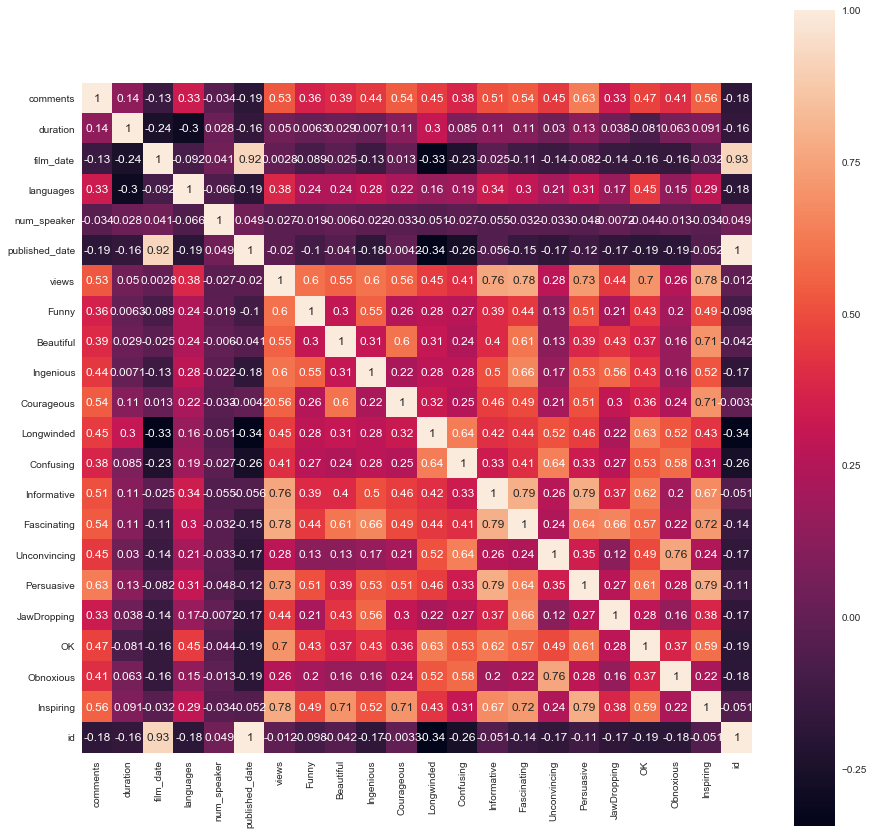

In [17]:
df = dfOrig
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(data=df.corr(), annot=True, square=True)
plt.show()

We try again, but removing columns that clearly have no impact or don't make sense to measure. We are dropping ID, published_date, film_date, num_speaker, and duration languages. However, it is possible we include film_date to potentially look at how Ted Talks have changed over time. We will also remove object columns that can't be regressed on. 

In [18]:
df = df.drop(['id', 'published_date', 'film_date', 'num_speaker', 'duration','languages'], axis=1)
df = df.select_dtypes(['int64'])

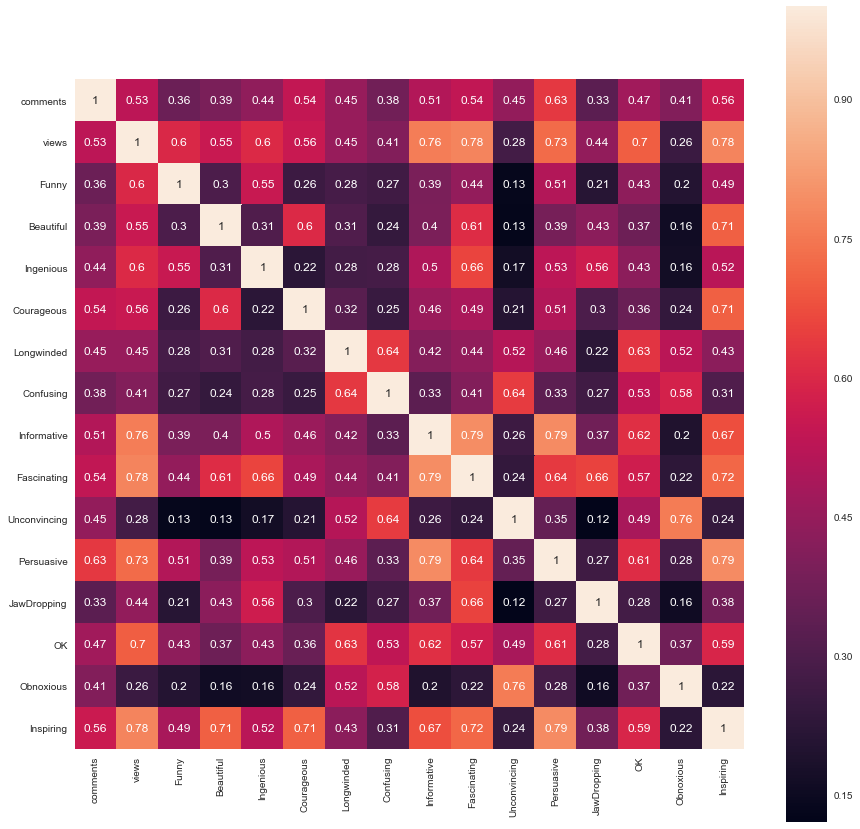

In [19]:
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(data=df.corr(), annot=True, square=True)
plt.show()

Here we are left with all the different rating types, views and comments. We now explore which ratings best indicate high views, and also high comments. We start by regressing with views as the dependent variables. First, we do a test train split on our data.

In [20]:
#Split the data
dfTrain, dfTest = train_test_split(df, test_size = .2)
X_train = dfTrain.drop(['views','comments'],axis=1)
X_test = dfTest.drop(['views','comments'],axis=1)
y_train = dfTrain['views']
y_test = dfTest['views']

#Create the LinearRegression object
LR = LinearRegression()
LR.fit(X_train,y_train)

#Observe the coefficents and score
string = ""
coef = LR.coef_
colNames = list(X_train)
order = np.argsort(coef)
for i in order:
    string += "The coefficent for " + colNames[i] + " is " + str(coef[i]) + "\n"
print string
print "The R^2 for the training split is:", LR.score(X_train, y_train)
print "The R^2 for the test split is:", LR.score(X_test,y_test)

The coefficent for Longwinded is -4408.60386637
The coefficent for Unconvincing is -1245.02479685
The coefficent for Obnoxious is -563.404461317
The coefficent for JawDropping is 76.2668569387
The coefficent for Beautiful is 167.329474579
The coefficent for Persuasive is 223.72397495
The coefficent for Inspiring is 252.834610167
The coefficent for Fascinating is 562.426565665
The coefficent for Courageous is 575.628076521
The coefficent for Ingenious is 674.675455571
The coefficent for Funny is 1001.73962221
The coefficent for Informative is 1037.4309973
The coefficent for Confusing is 4960.25496718
The coefficent for OK is 7384.94499554

The R^2 for the training split is: 0.77964224819
The R^2 for the test split is: 0.87922083092


There are some really odd ratings in here near the top. It's suprising to see that Confusing and OK have the two highest coefficents. Conversely it doesn't make sense to see persuasive and jaw-dropping near the bottom. We now look into a polynomial feature model.

In [21]:
poly2 = PolynomialFeatures(2)
fit2 = poly2.fit_transform(X_train)
LR.fit(fit2, y_train)
LR.coef_

array([  3.94764265e-08,   6.04958467e+02,  -2.42820914e+02,
        -2.74178262e+02,  -4.38263728e+01,  -3.12688662e+03,
        -4.46836547e+03,  -9.70070484e+01,   1.15608533e+03,
        -8.20286923e+02,  -2.55397094e+02,   1.39690036e+03,
         3.44487742e+03,  -1.00186452e+03,   9.13914130e+02,
         3.47575001e-01,   2.97164933e-01,  -8.48009089e-01,
         8.99176580e-01,   4.22227421e+00,   1.79571691e+01,
         1.78379634e-01,   3.80394398e-01,   7.89181416e+00,
         1.62657172e-01,   2.35292625e-01,  -5.02178427e+00,
        -1.03036766e+01,  -4.79518659e-01,   8.08614681e-03,
         1.11595766e+00,   3.19609243e-01,   1.73829152e+01,
        -9.32765674e+00,   6.22757773e-01,   2.76803681e-03,
        -3.43908555e+00,  -1.93178605e+00,  -2.07056986e-01,
        -5.84383754e+00,  -3.72447483e+00,   4.27478110e-01,
        -1.58133307e-01,   6.92007795e-01,  -1.25039397e+01,
         8.97619904e-02,  -5.57599997e-01,  -2.19291466e-02,
         7.76737537e+00,

Note that none of these coeficents are very large, which leads me to believe that a model with polynomial features of degree 2 overfits the data. We now investigate if there is colinearity among the other variables.

In [22]:
for i in range(0,len(colNames)):
    regressWith = X_train.copy()
    regressOn = regressWith[colNames[i]]
    del regressWith[colNames[i]]
    LR.fit(regressWith,regressOn)
    vif = 1/(1-LR.score(regressWith,regressOn))
    print "The VIF for {0} is: {1}".format(colNames[i],vif)

The VIF for Funny is: 1.39770480261
The VIF for Beautiful is: 2.87065881759
The VIF for Ingenious is: 2.18426635088
The VIF for Courageous is: 2.35107279122
The VIF for Longwinded is: 2.17747702411
The VIF for Confusing is: 2.44920350346
The VIF for Informative is: 5.43547458419
The VIF for Fascinating is: 7.64044284637
The VIF for Unconvincing is: 3.49786524067
The VIF for Persuasive is: 4.77064273023
The VIF for JawDropping is: 3.13815691011
The VIF for OK is: 2.60467213712
The VIF for Obnoxious is: 3.27069033472
The VIF for Inspiring is: 6.39476554319


Thus, we drop Inspiring and see if that changes anything

In [23]:
X_train = X_train.drop(['Inspiring'], axis=1)
X_test = X_test.drop(['Inspiring'], axis = 1)

In [24]:
LR.fit(X_train,y_train)

#Observe the coefficents and score
string = ""
coef = LR.coef_
colNames = list(X_train)
order = np.argsort(coef)
for i in order:
    string += "The coefficent for " + colNames[i] + " is " + str(coef[i]) + "\n"
print string
print "The R^2 for the training split is:", LR.score(X_train, y_train)
print "The R^2 for the test split is:", LR.score(X_test,y_test)

The coefficent for Longwinded is -4521.24575867
The coefficent for Unconvincing is -1273.99668985
The coefficent for Obnoxious is -1065.74917763
The coefficent for JawDropping is 6.64064069226
The coefficent for Beautiful is 382.872912511
The coefficent for Persuasive is 566.753073631
The coefficent for Fascinating is 662.031871828
The coefficent for Courageous is 759.034934455
The coefficent for Ingenious is 793.123044798
The coefficent for Informative is 968.925356891
The coefficent for Funny is 1009.953781
The coefficent for Confusing is 4690.03982869
The coefficent for OK is 7786.73553104

The R^2 for the training split is: 0.776866738007
The R^2 for the test split is: 0.870521543607


We now regress on number of comments, looking to see which ratings go along most with discussion provoking Ted Talks

In [25]:
#Split the data
dfTrain, dfTest = train_test_split(df, test_size = .2)
X_train = dfTrain.drop(['views','comments'],axis=1)
X_test = dfTest.drop(['views','comments'],axis=1)
y_train = dfTrain['comments']
y_test = dfTest['comments']

#Create the LinearRegression object
LR.fit(X_train,y_train)

#Observe the coefficents and score
string = ""
coef = LR.coef_
colNames = list(X_train)
order = np.argsort(coef)
for i in order:
    string += "The coefficent for " + colNames[i] + " is " + str(coef[i]) + "\n"
print string
print "The R^2 for the training split is:", LR.score(X_train, y_train)
print "The R^2 for the test split is:", LR.score(X_test,y_test)

The coefficent for Confusing is -0.444293544364
The coefficent for Informative is -0.0762924222947
The coefficent for Inspiring is -0.056927358967
The coefficent for JawDropping is -0.00343710438677
The coefficent for Funny is 0.00515005213466
The coefficent for OK is 0.00592635272801
The coefficent for Beautiful is 0.0748080555528
The coefficent for Obnoxious is 0.0778704965435
The coefficent for Fascinating is 0.0829438779982
The coefficent for Ingenious is 0.139727480601
The coefficent for Courageous is 0.173257968759
The coefficent for Persuasive is 0.283897787273
The coefficent for Longwinded is 0.366044848159
The coefficent for Unconvincing is 0.631727835528

The R^2 for the training split is: 0.601587635981
The R^2 for the test split is: 0.463854285783


In [26]:
for i in range(0,len(colNames)):
    regressWith = X_train.copy()
    regressOn = regressWith[colNames[i]]
    del regressWith[colNames[i]]
    LR.fit(regressWith,regressOn)
    vif = 1/(1-LR.score(regressWith,regressOn))
    print "The VIF for {0} is: {1}".format(colNames[i],vif)

The VIF for Funny is: 1.85981302506
The VIF for Beautiful is: 3.6270361433
The VIF for Ingenious is: 2.70412485676
The VIF for Courageous is: 2.38140575071
The VIF for Longwinded is: 2.25236409879
The VIF for Confusing is: 2.46021620695
The VIF for Informative is: 5.5035469495
The VIF for Fascinating is: 7.17824890886
The VIF for Unconvincing is: 3.08456911081
The VIF for Persuasive is: 5.93165946335
The VIF for JawDropping is: 2.28944815678
The VIF for OK is: 2.72272538026
The VIF for Obnoxious is: 2.57791463068
The VIF for Inspiring is: 7.57941621071


In [27]:
X_train = X_train.drop(['Fascinating','Inspiring'], axis=1)
X_test = X_test.drop(['Fascinating', 'Inspiring'], axis=1)

In [28]:
LR.fit(X_train,y_train)

string = ""
coef = LR.coef_
colNames = list(X_train)
order = np.argsort(coef)
for i in order:
    string += "The coefficent for " + colNames[i] + " is " + str(coef[i]) + "\n"
print string
print "The R^2 for the training split is:", LR.score(X_train, y_train)
print "The R^2 for the test split is:", LR.score(X_test,y_test)

The coefficent for Confusing is -0.236691112898
The coefficent for OK is -0.0935295157938
The coefficent for Informative is -0.0178844713614
The coefficent for Funny is 0.00534747370229
The coefficent for JawDropping is 0.0233352391669
The coefficent for Beautiful is 0.0434286907201
The coefficent for Obnoxious is 0.0848192340408
The coefficent for Courageous is 0.133364179913
The coefficent for Ingenious is 0.141813291582
The coefficent for Persuasive is 0.196286521508
The coefficent for Longwinded is 0.476777735169
The coefficent for Unconvincing is 0.652244918913

The R^2 for the training split is: 0.585933253833
The R^2 for the test split is: 0.440197530869


# A look at the tags

Let's explore

In [52]:
df = dfOrig.copy()

# Turn tags column to string
df['tags'] = df['tags'].apply(ast.literal_eval)
df['tags'] = df['tags'].apply(' '.join) 

We define a function that will stem our tags for us

In [53]:
def filter_words(review):
    """
    Return a pre-processed review string
    
    Parameters:
    ------------
    review: (original) review text, string
    
    Returns:
    -------------
    fitered: a filtered string
    """
    stemmer = PorterStemmer()
    review = review.lower()
    review = review.replace('español', 'espanol')
    wordTokens = word_tokenize(review)
    filtered = wordTokens
    #filtered = map(lambda x: stemmer.stem(x), filtered)
    filtered = ' '.join(filtered)
    return filtered

df['tags'] = df['tags'].apply(filter_words)

We now create a count vector and build our vocabulary

In [54]:
countVect= CountVectorizer()
countVect.fit(df['tags'])
vocab = countVect.vocabulary_
print "The size of vocabulary is {0}.".format(len(vocab))

The size of vocabulary is 440.


We now have our vocab, we now create our matrices, as well as a matrix based off a new column which is based on the if a video has 'outlier' views of not

In [55]:
outlierValue = df['views'].quantile(.75) + (df['views'].quantile(.75)-df['views'].quantile(.25))*1.5
df['outlier'] = np.where(df['views']>=outlierValue, True, False)

X = countVect.fit_transform(df['tags'])
y = df.as_matrix(['outlier']).ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

# Naive Bayes
NB = MultinomialNB()
NB.fit(X_train, y_train)
NBTrainAcc = NB.score(X_train,y_train)
NBTestAcc = NB.score(X_test,y_test)

# Logistic Regression
LR = LogisticRegression()
LR.fit(X_train,y_train)
LRTrainAcc = LR.score(X_train,y_train)
LRTestAcc = LR.score(X_test,y_test)

print "Naive Bayes Training Accuracy:", NBTrainAcc
print "Naive Bayes Test Accuracy:", NBTestAcc
print "Logistic Regression Training Accuracy:", LRTrainAcc
print "Logistic Regression Test Accuracy:", LRTestAcc

Naive Bayes Training Accuracy: 0.884006131834
Naive Bayes Test Accuracy: 0.842857142857
Logistic Regression Training Accuracy: 0.914154317833
Logistic Regression Test Accuracy: 0.918367346939


Let's take a look at the tags that generated the most views

In [67]:
tagCoefPairs = dict(zip(vocab.keys(),LR.coef_[0].tolist()))
tagCoefPairs = sorted(tagCoefPairs.items(), key = lambda x: x[1], reverse=True)
tagCoefPairs

[(u'ai', 1.3217852201955107),
 (u'animals', 1.2548784041862624),
 (u'conservation', 1.1715495545799002),
 (u'garden', 1.1434939665103798),
 (u'fellows', 1.0964329674519284),
 (u'sanitation', 1.0906165893104265),
 (u'failure', 1.0043051939918297),
 (u'geology', 1.0041642453009123),
 (u'mindfulness', 0.9996800941487243),
 (u'pain', 0.9960223035665785),
 (u'population', 0.9882745622123652),
 (u'tedx', 0.9787847226598407),
 (u'europe', 0.9563576699864546),
 (u'privacy', 0.9265185660222932),
 (u'agriculture', 0.8829174563968183),
 (u'literature', 0.8472427496771936),
 (u'food', 0.8296711257918561),
 (u'sight', 0.7547441835182537),
 (u'poverty', 0.7499068837529946),
 (u'forensics', 0.7148323205149272),
 (u'pollution', 0.7102075884797898),
 (u'3d', 0.6951186660785941),
 (u'prison', 0.6908342351915306),
 (u'google', 0.6719115800123471),
 (u'online', 0.6712199040839669),
 (u'introvert', 0.6701399523557434),
 (u'adventure', 0.6566091940699019),
 (u'journalism', 0.6540582878189595),
 (u'drones', 

In [68]:
tagCoefPairs = dict(zip(vocab.keys(),NB.coef_[0].tolist()))
tagCoefPairs = sorted(tagCoefPairs.items(), key = lambda x: x[1], reverse=True)
tagCoefPairs

[(u'poverty', -3.233537052663962),
 (u'violin', -3.495901317131453),
 (u'complexity', -3.579282926070504),
 (u'cultures', -3.7443626764299527),
 (u'rivers', -3.8525762610701855),
 (u'sexual', -4.006726940897444),
 (u'education', -4.040628492573125),
 (u'paleontology', -4.11208745655527),
 (u'tedx', -4.189048497691399),
 (u'pregnancy', -4.316881869201283),
 (u'disaster', -4.3634018848361755),
 (u'surgery', -4.463485343393159),
 (u'learning', -4.574710978503383),
 (u'museums', -4.635335600319818),
 (u'privacy', -4.699874121457389),
 (u'pollution', -4.699874121457389),
 (u'statistics', -4.699874121457389),
 (u'sex', -4.768866992944341),
 (u'innovation', -4.768866992944341),
 (u'atheism', -4.923017672771598),
 (u'men', -5.010029049761228),
 (u'travel', -5.010029049761228),
 (u'pain', -5.010029049761228),
 (u'conservation', -5.010029049761228),
 (u'sustainability', -5.105339229565553),
 (u'dna', -5.21069974522338),
 (u'garden', -5.21069974522338),
 (u'cars', -5.21069974522338),
 (u'and', -5

We now repeat our analysis for tags but looking at videos that produce an outlier amount of comments.

In [58]:
outlierValue = df['comments'].quantile(.75) + (df['comments'].quantile(.75)-df['comments'].quantile(.25))*1.5
df['outlier'] = np.where(df['comments']>=outlierValue, True, False)

X = countVect.fit_transform(df['tags'])
y = df.as_matrix(['outlier']).ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

# Naive Bayes
NB = MultinomialNB()
NB.fit(X_train, y_train)
NBTrainAcc = NB.score(X_train,y_train)
NBTestAcc = NB.score(X_test,y_test)

# Logistic Regression
LR = LogisticRegression()
LR.fit(X_train,y_train)
LRTrainAcc = LR.score(X_train,y_train)
LRTestAcc = LR.score(X_test,y_test)

print "Naive Bayes Training Accuracy:", NBTrainAcc
print "Naive Bayes Test Accuracy:", NBTestAcc
print "Logistic Regression Training Accuracy:", LRTrainAcc
print "Logistic Regression Test Accuracy:", LRTestAcc

Naive Bayes Training Accuracy: 0.900868676546
Naive Bayes Test Accuracy: 0.908163265306
Logistic Regression Training Accuracy: 0.932038834951
Logistic Regression Test Accuracy: 0.926530612245


In [59]:
tagCoefPairs = dict(zip(vocab.keys(),LR.coef_[0].tolist()))
sorted(tagCoefPairs.items(), key = lambda x: x[1], reverse=True)

[(u'ai', 1.3217852201955107),
 (u'animals', 1.2548784041862624),
 (u'conservation', 1.1715495545799002),
 (u'garden', 1.1434939665103798),
 (u'fellows', 1.0964329674519284),
 (u'sanitation', 1.0906165893104265),
 (u'failure', 1.0043051939918297),
 (u'geology', 1.0041642453009123),
 (u'mindfulness', 0.9996800941487243),
 (u'pain', 0.9960223035665785),
 (u'population', 0.9882745622123652),
 (u'tedx', 0.9787847226598407),
 (u'europe', 0.9563576699864546),
 (u'privacy', 0.9265185660222932),
 (u'agriculture', 0.8829174563968183),
 (u'literature', 0.8472427496771936),
 (u'food', 0.8296711257918561),
 (u'sight', 0.7547441835182537),
 (u'poverty', 0.7499068837529946),
 (u'forensics', 0.7148323205149272),
 (u'pollution', 0.7102075884797898),
 (u'3d', 0.6951186660785941),
 (u'prison', 0.6908342351915306),
 (u'google', 0.6719115800123471),
 (u'online', 0.6712199040839669),
 (u'introvert', 0.6701399523557434),
 (u'adventure', 0.6566091940699019),
 (u'journalism', 0.6540582878189595),
 (u'drones', 

In [60]:
tagCoefPairs = dict(zip(vocab.keys(),NB.coef_[0].tolist()))
sorted(tagCoefPairs.items(), key = lambda x: x[1], reverse=True)

[(u'poverty', -3.233537052663962),
 (u'violin', -3.495901317131453),
 (u'complexity', -3.579282926070504),
 (u'cultures', -3.7443626764299527),
 (u'rivers', -3.8525762610701855),
 (u'sexual', -4.006726940897444),
 (u'education', -4.040628492573125),
 (u'paleontology', -4.11208745655527),
 (u'tedx', -4.189048497691399),
 (u'pregnancy', -4.316881869201283),
 (u'disaster', -4.3634018848361755),
 (u'surgery', -4.463485343393159),
 (u'learning', -4.574710978503383),
 (u'museums', -4.635335600319818),
 (u'privacy', -4.699874121457389),
 (u'pollution', -4.699874121457389),
 (u'statistics', -4.699874121457389),
 (u'sex', -4.768866992944341),
 (u'innovation', -4.768866992944341),
 (u'atheism', -4.923017672771598),
 (u'men', -5.010029049761228),
 (u'travel', -5.010029049761228),
 (u'pain', -5.010029049761228),
 (u'conservation', -5.010029049761228),
 (u'sustainability', -5.105339229565553),
 (u'dna', -5.21069974522338),
 (u'garden', -5.21069974522338),
 (u'cars', -5.21069974522338),
 (u'and', -5